In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [21]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [22]:
# Hyperparameters
batch_size = 128  # Large batch size for faster training
learning_rate = 0.001
epochs = 25

In [24]:
# Enhanced Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [25]:
# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [26]:
# Model Architecture
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(128 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = CIFAR10_CNN().to(device)

In [27]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

In [28]:
# Training function
def train(epoch):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/(epoch+1))

    return running_loss / len(train_loader)

In [29]:
# Testing function
def test():
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

In [30]:
# Training loop
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    loss = train(epoch)
    accuracy = test()
    scheduler.step(loss)  # Adjust learning rate

    train_losses.append(loss)
    test_accuracies.append(accuracy)

print("Training Complete!")

Epoch 1/25: 100%|██████████| 391/391 [00:22<00:00, 17.09it/s, loss=498]


Test Accuracy: 66.79%


Epoch 2/25: 100%|██████████| 391/391 [00:21<00:00, 18.19it/s, loss=173]


Test Accuracy: 71.52%


Epoch 3/25: 100%|██████████| 391/391 [00:22<00:00, 17.73it/s, loss=99]


Test Accuracy: 77.34%


Epoch 4/25: 100%|██████████| 391/391 [00:21<00:00, 18.08it/s, loss=67.1]


Test Accuracy: 79.06%


Epoch 5/25: 100%|██████████| 391/391 [00:20<00:00, 19.07it/s, loss=49.1]


Test Accuracy: 78.50%


Epoch 6/25: 100%|██████████| 391/391 [00:21<00:00, 18.26it/s, loss=38]


Test Accuracy: 81.14%


Epoch 7/25: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s, loss=30.4]


Test Accuracy: 80.89%


Epoch 8/25: 100%|██████████| 391/391 [00:21<00:00, 18.03it/s, loss=25.4]


Test Accuracy: 84.13%


Epoch 9/25: 100%|██████████| 391/391 [00:21<00:00, 18.07it/s, loss=21.2]


Test Accuracy: 84.09%


Epoch 10/25: 100%|██████████| 391/391 [00:21<00:00, 18.35it/s, loss=18.3]


Test Accuracy: 83.22%


Epoch 11/25: 100%|██████████| 391/391 [00:20<00:00, 18.93it/s, loss=15.9]


Test Accuracy: 85.66%


Epoch 12/25: 100%|██████████| 391/391 [00:21<00:00, 18.32it/s, loss=14]


Test Accuracy: 84.84%


Epoch 13/25: 100%|██████████| 391/391 [00:21<00:00, 17.97it/s, loss=12.2]


Test Accuracy: 85.29%


Epoch 14/25: 100%|██████████| 391/391 [00:21<00:00, 18.00it/s, loss=11]


Test Accuracy: 86.71%


Epoch 15/25: 100%|██████████| 391/391 [00:21<00:00, 18.10it/s, loss=9.83]


Test Accuracy: 86.99%


Epoch 16/25: 100%|██████████| 391/391 [00:21<00:00, 18.01it/s, loss=8.97]


Test Accuracy: 86.48%


Epoch 17/25: 100%|██████████| 391/391 [00:20<00:00, 19.02it/s, loss=8.01]


Test Accuracy: 86.59%


Epoch 18/25: 100%|██████████| 391/391 [00:21<00:00, 18.61it/s, loss=7.34]


Test Accuracy: 86.97%


Epoch 19/25: 100%|██████████| 391/391 [00:21<00:00, 18.10it/s, loss=6.7]


Test Accuracy: 86.96%


Epoch 20/25: 100%|██████████| 391/391 [00:22<00:00, 17.75it/s, loss=6.22]


Test Accuracy: 86.97%


Epoch 21/25: 100%|██████████| 391/391 [00:22<00:00, 17.63it/s, loss=5.62]


Test Accuracy: 87.40%


Epoch 22/25: 100%|██████████| 391/391 [00:22<00:00, 17.66it/s, loss=5.28]


Test Accuracy: 88.20%


Epoch 23/25: 100%|██████████| 391/391 [00:22<00:00, 17.58it/s, loss=4.93]


Test Accuracy: 88.18%


Epoch 24/25: 100%|██████████| 391/391 [00:21<00:00, 18.17it/s, loss=4.56]


Test Accuracy: 88.17%


Epoch 25/25: 100%|██████████| 391/391 [00:21<00:00, 18.43it/s, loss=4.3]


Test Accuracy: 87.79%


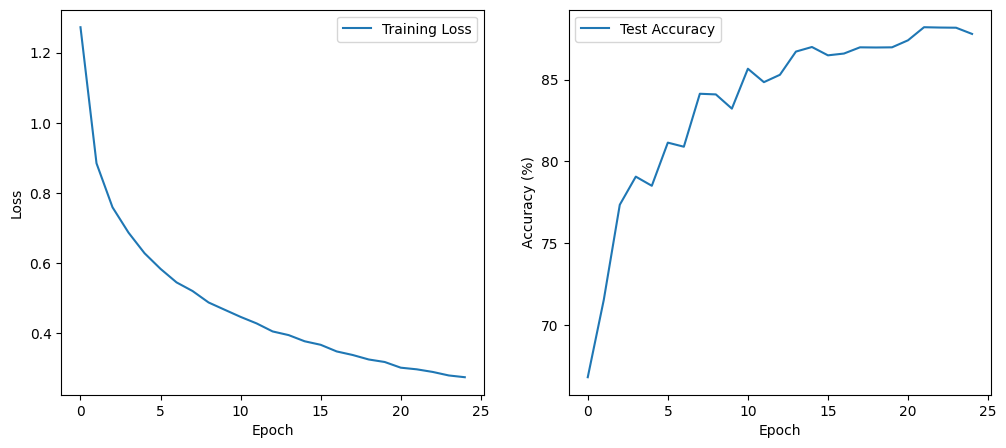

In [31]:
# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

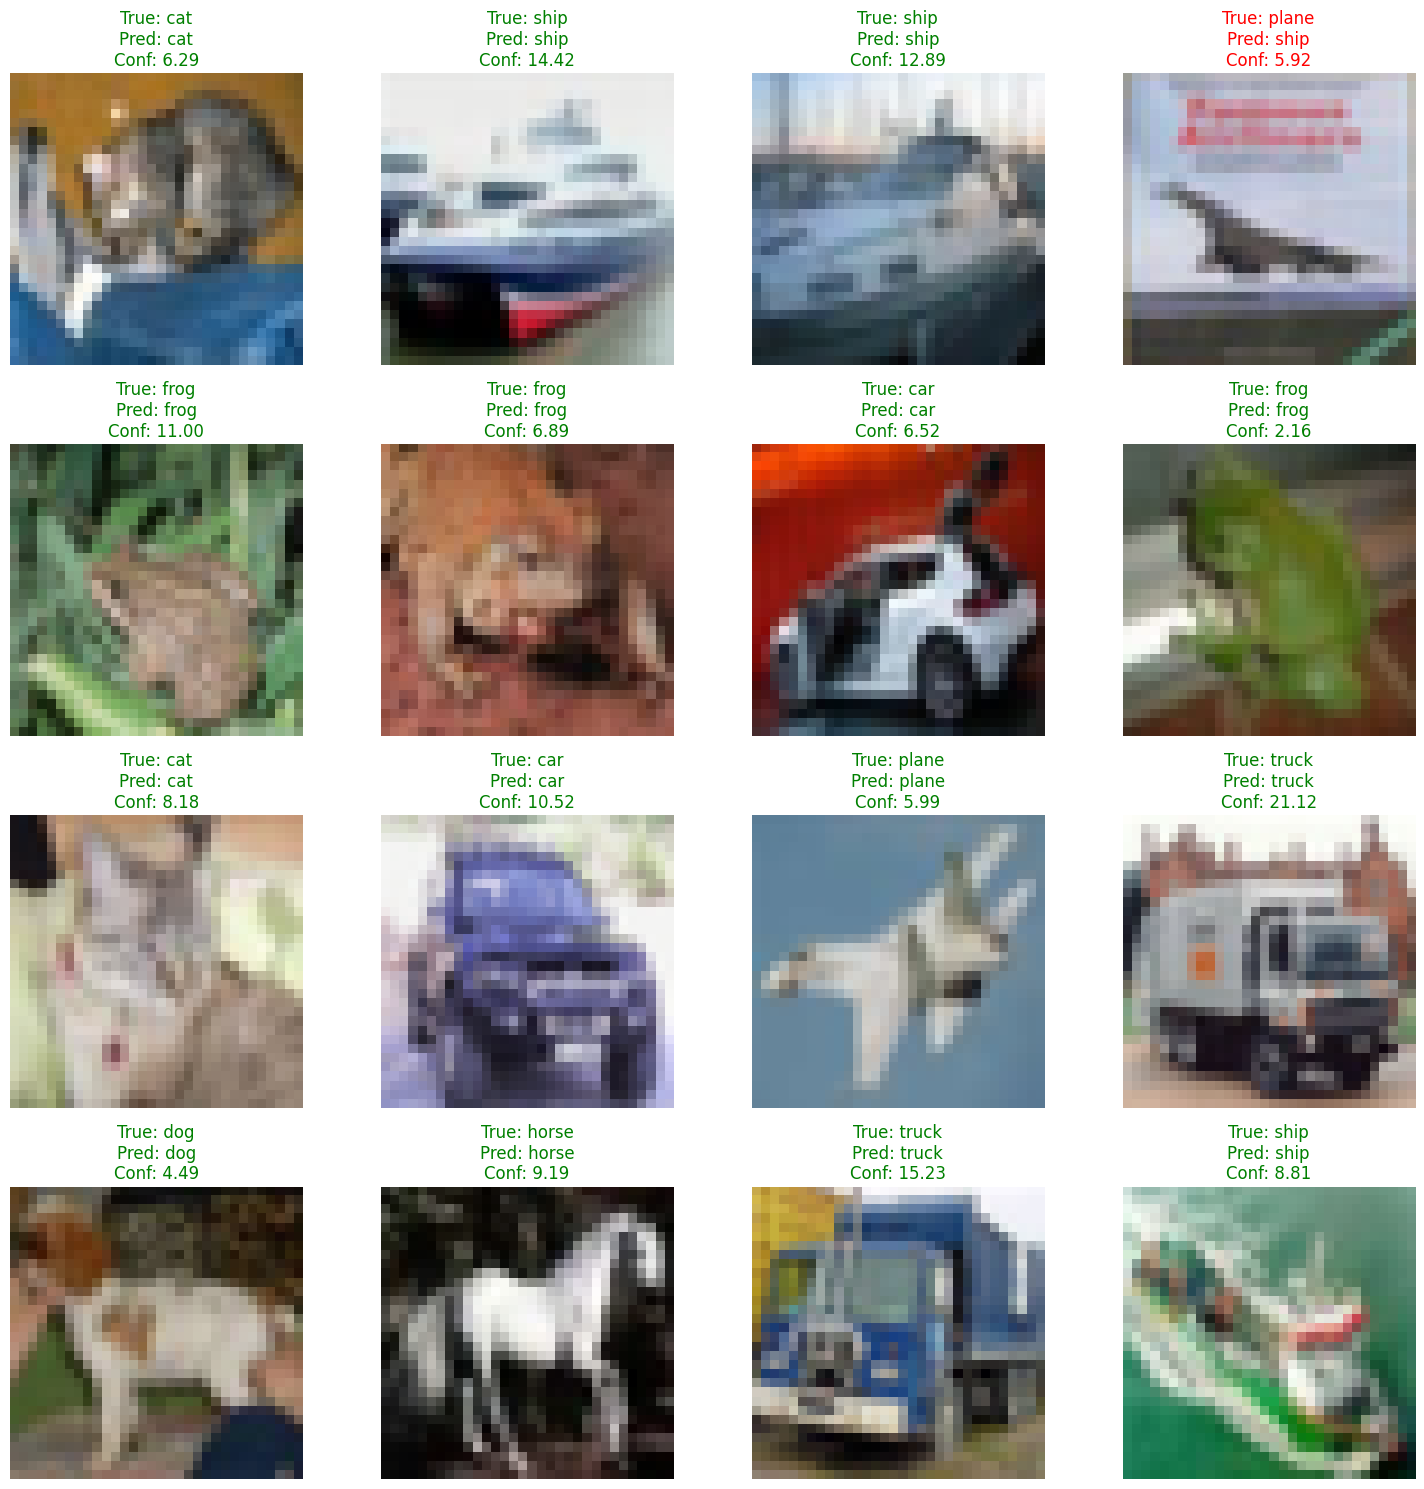


Final Test Accuracy: 87.79%


In [38]:
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def evaluate_and_visualize(model, test_loader, num_images=16):
    """Combined function that returns metrics AND shows predictions"""
    # Evaluation part (returns values)
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        # First pass to get all predictions
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            max_values, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total

    # Visualization part
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    with torch.no_grad():
        outputs = model(images)
        class_scores, preds = torch.max(outputs, 1)

    # Prepare visualization
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for idx, ax in enumerate(axes.flat):
        if idx >= num_images:
            break

        # Unnormalize image
        img = images[idx].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)

        # Display
        ax.imshow(img)
        true_name = class_names[labels[idx]]
        pred_name = class_names[preds[idx]]
        confidence = class_scores[idx].item()
        color = 'green' if true_name == pred_name else 'red'
        ax.set_title(f"True: {true_name}\nPred: {pred_name}\nConf: {confidence:.2f}", color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    return all_preds, all_labels, accuracy

predictions, true_labels, final_acc = evaluate_and_visualize(model, test_loader)
print(f"\nFinal Test Accuracy: {final_acc:.2f}%")